In [1]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import Xception, ResNet152
from tensorflow.keras import Sequential
from kerastuner import HyperModel, HyperParameters, RandomSearch
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import tensorflow as tf
import os

## Constants and Functions

In [2]:
SEED = 121199
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 50
NUM_CLASSES = 5
BATCH_SIZE = 32

def visualize_result(his, epochs, filename):
    acc = his.history['accuracy']
    val_acc = his.history['val_accuracy']

    loss = his.history['loss']
    val_loss = his.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig(filename)
    plt.show()

## Acquire Data

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import zipfile
# with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20)

test_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
)

val_ds = test_datagen.flow_from_directory(
    'dataset/val',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
)

test_ds = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
)

# AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3237 images belonging to 5 classes.
Found 604 images belonging to 5 classes.
Found 208 images belonging to 5 classes.


## Model Architecture and HP Tuning

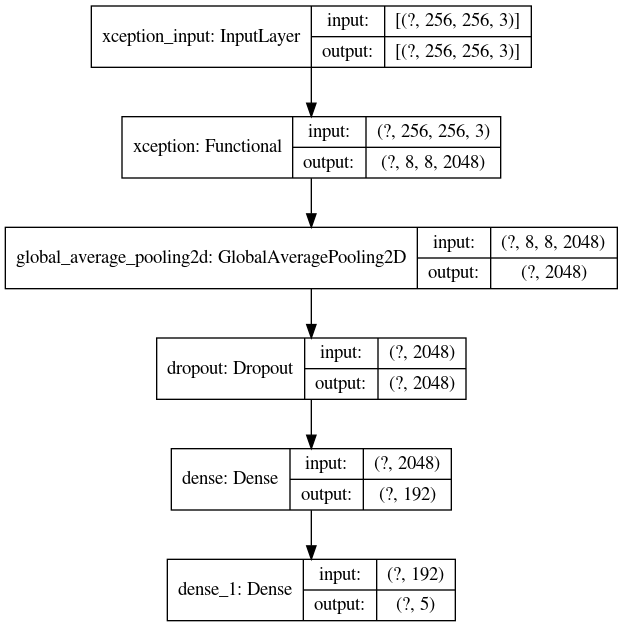

In [4]:
from tensorflow.keras.applications import Xception

xception_base = Xception(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# xception_base.summary()

cervix_net = Sequential([
    xception_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(.2, seed=SEED),
    layers.Dense(192, activation='tanh'),       # fully connected layers
    layers.Dense(NUM_CLASSES, activation='softmax')         # output layer
])

keras.utils.plot_model(cervix_net, to_file="img/xception_arch.png", show_shapes=True)

In [103]:
import json

# -- PREPROCESSING SEQUENCE -- #
normalization_layer = layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
data_augmentation = layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical')

# -- CONVOLUTIONAL BASE -- #
xception_base = Xception(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# resnet_base = ResNet152(include_top=False, input_shape=(256, 256, 3))
# freeze all but last 2 separable conv block
for layer in xception_base.layers[:(len(xception_base.layers) - 16)]:
    layer.trainable = False

# -- HYPER MODEL -- #
class HyperCervixNet(HyperModel):
    def __init__(self):
        super().__init__()

    def build(self, hp):
        # hp search space
        fc_units = hp.Int('fc_units', min_value=32, max_value=512,
                          step=32, default=128)
        fc_activation = hp.Choice('fc_activation',
                                  values=['relu', 'tanh', 'sigmoid'],
                                  default='relu')
        # model assembly
        cervix_net = Sequential([
            layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
            layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'),
            xception_base,
            layers.GlobalAveragePooling2D(),
            layers.Dense(fc_units, activation=fc_activation),       # fully connected layers
            layers.Dense(NUM_CLASSES, activation='softmax')         # output layer
        ])

        cervix_net.summary()
        
        # decaying learning rate
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-2,
            decay_steps=10000,
            decay_rate=0.9)
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
        # compile the model
        cervix_net.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])
        return cervix_net
    
hypermodel = HyperCervixNet()

# -- TUNER -- #
MAX_TRIALS = 10
EXECUTION_PER_TRIAL = 2
SEARCH_EPOCHS = 40

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search',
    project_name='cervix_net',
)
tuner.search_space_summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0.001, patience=3,
        mode='auto', baseline=None, restore_best_weights=True)
]

# x_train, y_train = [x, y for x, y in train_ds]
tuner.search(train_ds, epochs=SEARCH_EPOCHS, validation_data=val_ds, callbacks=callbacks)
# Show a summary of the search
tuner.results_summary()
best_hp = tuner.get_best_hyperparameters()[0]
with open('xception_best_hp.json', 'w') as f:
    json.dump(best_hp.get_config(), f)
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('cervixnet_best_mt{}_ept{}_se{}.h5'.format(MAX_TRIALS, EXECUTION_PER_TRIAL, SEARCH_EPOCHS))
# Evaluate the best model.
# loss, accuracy = best_model.evaluate(x_test, y_test)

INFO:tensorflow:Reloading Oracle from existing project random_search/cervix_net/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 21,124,397
Train

INFO:tensorflow:Oracle triggered exit


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 192)               393408    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 965       
Total params: 21,255,853
Trainable params: 7,182,757
Non-trainable params: 14,073,096
____________________________________

## Refitting the Model

Epoch 1/50
102/102 - 55s - loss: 0.1340 - accuracy: 0.9784 - val_loss: 0.4038 - val_accuracy: 0.9255
Epoch 2/50
102/102 - 53s - loss: 0.1178 - accuracy: 0.9756 - val_loss: 0.5069 - val_accuracy: 0.9354
Epoch 3/50
102/102 - 53s - loss: 0.0755 - accuracy: 0.9846 - val_loss: 0.3480 - val_accuracy: 0.9503
Epoch 4/50
102/102 - 53s - loss: 0.1341 - accuracy: 0.9737 - val_loss: 0.5382 - val_accuracy: 0.9106
Epoch 5/50
102/102 - 53s - loss: 0.0869 - accuracy: 0.9824 - val_loss: 0.5139 - val_accuracy: 0.9222
Epoch 6/50
102/102 - 53s - loss: 0.1128 - accuracy: 0.9762 - val_loss: 0.4345 - val_accuracy: 0.9387
Epoch 7/50
102/102 - 53s - loss: 0.0650 - accuracy: 0.9886 - val_loss: 0.3935 - val_accuracy: 0.9338
Epoch 8/50
102/102 - 53s - loss: 0.0486 - accuracy: 0.9880 - val_loss: 0.5870 - val_accuracy: 0.9139
Epoch 9/50
102/102 - 53s - loss: 0.0569 - accuracy: 0.9842 - val_loss: 0.4510 - val_accuracy: 0.9404
Epoch 10/50
102/102 - 53s - loss: 0.0381 - accuracy: 0.9926 - val_loss: 0.3792 - val_accura

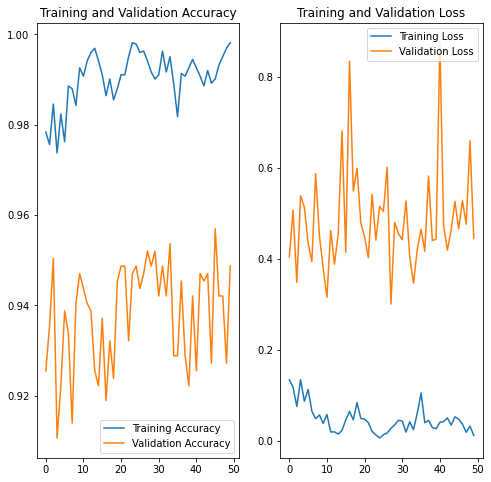

In [104]:
import time

fit_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=1e-4, patience=5,
        mode='auto', baseline=0.1, restore_best_weights=False)
]
start = time.time()
history = best_model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=2)
end = time.time() - start
print(history.history)
n_epochs_best = len(history.history['val_loss'])

filename = 'cervixnet_best_refit_e{}'.format(n_epochs_best)
best_model.save('models/{}.h5'.format(filename))
visualize_result(history, n_epochs_best, 'img/' + filename + '.png')

## Evaluating the Model

In [105]:
loss, acc = best_model.evaluate(test_ds)
print('Loss: {}\nAccuracy: {}'.format(loss, acc))

7/7 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.96 - ETA: 0s - loss: 0.3476 - accuracy: 0.96 - ETA: 0s - loss: 0.2394 - accuracy: 0.96 - ETA: 0s - loss: 0.2068 - accuracy: 0.96 - ETA: 0s - loss: 0.2846 - accuracy: 0.96 - ETA: 0s - loss: 0.2434 - accuracy: 0.96 - ETA: 0s - loss: 0.2783 - accuracy: 0.96 - 2s 300ms/step - loss: 0.2783 - accuracy: 0.9668
Loss: 0.2782607674598694
Accuracy: 0.9668246507644653


## Training

In [ ]:
import datetime
import time

fit_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=1e-3, patience=10,
        mode='min', baseline=None, restore_best_weights=True)
]
# decaying learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
# compile the model
cervix_net.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

start = time.time()
history = cervix_net.fit(train_ds, epochs=100, validation_data=val_ds, verbose=2)
end = time.time() - start
print('Training time: {}'.format(datetime.timedelta(seconds=end)))

n_epochs_best = len(history.history['val_loss'])
filename = 'xception_fit_e{}'.format(n_epochs_best)
concat_model.save('models/{}.h5'.format(filename))
visualize_result(history, n_epochs_best, 'img/' + filename + '.png')

loss, acc = cervix_net.evaluate(test_ds)
print('Loss: {}\nAccuracy: {}'.format(loss, acc))